In [1]:
#%%
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sentence_transformers import SentenceTransformer

#%% import data
twitter_file = 'Tweets.csv'
df = pd.read_csv(twitter_file).dropna()
df

2024-12-13 15:41:33.077397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 15:41:33.154085: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 15:41:33.179918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 15:41:33.271946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 15:41:37.369558: W tensorflow/compiler/tf2

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [2]:
#%% Create Target Variable
cat_id = {'neutral': 1,
          'negative': 0,
          'positive': 2}

df['class'] = df['sentiment'].map(cat_id)

#%% Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 50
MAX_FEATURES = 10

In [3]:
#%% Embedding Model
emb_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

sentences = [ "Each sentence is converted"]
embeddings = emb_model.encode(sentences)
print(embeddings.squeeze().shape)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(768,)


In [4]:
#%% prepare X and y
X = emb_model.encode(df['text'].values)

with open("tweets_X.pkl", "wb") as output_file:
     pickle.dump(X, output_file)

with open("tweets_X.pkl", "rb") as input_file:
    X = pickle.load(input_file)

y = df['class'].values


In [5]:
#%% Train Val Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

# %%

In [6]:
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]
train_ds = SentimentData(X= X_train, y = y_train)
test_ds = SentimentData(X_test, y_test)


In [7]:
# %% Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)


In [8]:
# %% Model
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN = 10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x


#%% Model, Loss and Optimizer
model = SentimentModel(NUM_FEATURES = X_train.shape[1], NUM_CLASSES = 3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [9]:
# %% Model Training
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")


Epoch 0, Loss: 109.97896653413773
Epoch 1, Loss: 91.35435718297958
Epoch 2, Loss: 82.2828021645546
Epoch 3, Loss: 78.47258657217026
Epoch 4, Loss: 76.6418394446373
Epoch 5, Loss: 75.47680127620697
Epoch 6, Loss: 74.58263683319092
Epoch 7, Loss: 73.99051862955093
Epoch 8, Loss: 73.37276464700699
Epoch 9, Loss: 72.92168951034546
Epoch 10, Loss: 72.54434323310852
Epoch 11, Loss: 72.1704124212265
Epoch 12, Loss: 71.7844569683075
Epoch 13, Loss: 71.36756837368011
Epoch 14, Loss: 71.16972762346268
Epoch 15, Loss: 70.79845917224884
Epoch 16, Loss: 70.44148647785187
Epoch 17, Loss: 70.19858682155609
Epoch 18, Loss: 69.903788626194
Epoch 19, Loss: 69.43384158611298
Epoch 20, Loss: 69.11768490076065
Epoch 21, Loss: 68.96915751695633
Epoch 22, Loss: 68.64575350284576
Epoch 23, Loss: 68.3488155901432
Epoch 24, Loss: 68.18344211578369
Epoch 25, Loss: 67.77442353963852
Epoch 26, Loss: 67.3812390267849
Epoch 27, Loss: 67.20223033428192
Epoch 28, Loss: 66.97335785627365
Epoch 29, Loss: 66.621457666158

<Axes: >

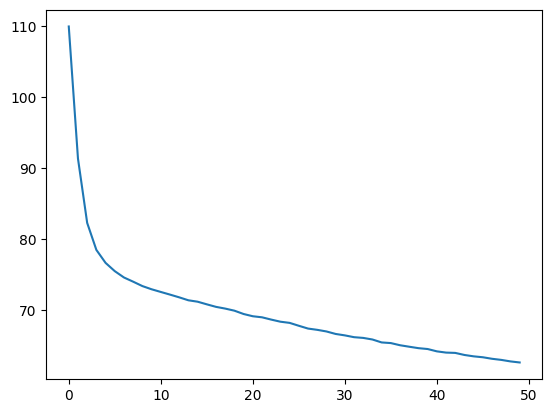

In [10]:
sns.lineplot(x=list(range(len(train_losses))), y= train_losses)

In [11]:
# %% Model Evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)

# %%

In [12]:
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()


In [13]:
# %%
acc = accuracy_score(y_pred=y_test_pred_np, y_true = y_test)
f"The accuracy of the model is {np.round(acc, 3)*100}%."

'The accuracy of the model is 68.60000000000001%.'

In [14]:
# %%
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_cnt / len(y_test) * 100, 1)} %")
# %%

Naive Classifier: 41.0 %
